# Utils.Display

> Fill in a module description here


In [ ]:
#| default_exp utils.display

In [ ]:
#| export
from fastcore.utils import *
from fastcore.utils import *
import cv2
import numpy as np
from imutils import resize
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.showdoc import *
from fastcore.test import *


In [ ]:
#|export
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

In [ ]:
#|export

# Todo Test for ipython  see def in_ipython(): in fastcore  or imports.py
def show_image(im
               , ax=None  # if None, a new figure is created
               , figsize=None # if None, the figure size is set to min of 5 and max of 1/32 of the image size
               , title=None # title of the image
               , text=None # text to be written on image
               , fontsize=12 # fontsize of text
               , ctx=None # context
               , **kwargs # kwargs for matplotlib
    )->plt.Axes: # return matplotlib axis
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    
    if text is not None:
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        # Compute the height of the image in data units
        image_height = ymax - ymin
        image_width = xmax - xmin
        # Set the position of the text to be 10% of the image height
        text_height = -0.1 * image_height
        text_width = 0.05 * image_width
        xpos = text_width
        ypos = text_height
        ax.text(xpos, ypos, text, fontsize=fontsize, bbox=dict(facecolor='white', edgecolor='none', pad=0)) 
        
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

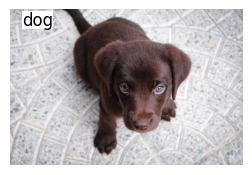

In [ ]:
im2 = np.array(Image.open(TEST_IMAGE))
ax = show_image(im2, text='dog', figsize=(3,3))

In [ ]:
#| export
def puttext(img
            , text:str    # text to be written on image
            , pos=(40,80)  # position of text
            , fontscale=2.0 # fontscale of text
            , thickness=2    # thickness of text
            , textcolor=(255,255,255)   # color of text
            , backcolor=(0,0,0)):   # color of background
    """ Place text on the image, the default position is the center of the image"""
    
    text_width, text_height = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontscale, 1)[0]
    
    if pos is None:
        pos = (img.shape[1]//2-text_width//2, img.shape[0]//2+text_height//2)
    
    rs_point = (pos[0]-2, pos[1]+2)
    re_point = (pos[0]+text_width+4, pos[1]-text_height-2)
    img = cv2.rectangle(img, rs_point, re_point, backcolor, -1)
    return cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, fontscale, textcolor, thickness, cv2.LINE_AA)

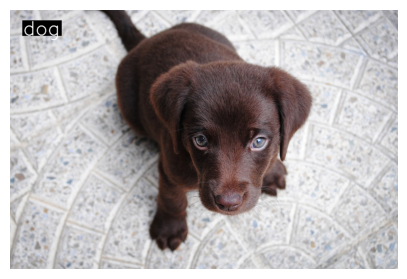

In [ ]:
im2 = np.array(Image.open(TEST_IMAGE))
im2 = puttext(im2, 'dog')
ax = show_image(im2)

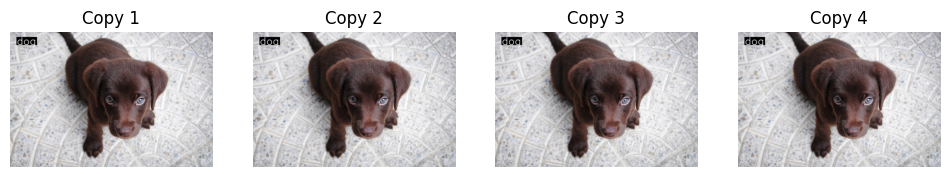

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,4))
for i,ax in enumerate(axs): show_image(im2, ax=ax, title=f'Copy {i+1}')

### VideoWriter   Todo change to opencv vido write

In [ ]:
#| export
class VideoWriter:
    def __init__(self, 
                 filename:str='_autoplay.mp4', # default filename
                 fps:float=30.0, #    fps of video
                 bgr2rgb:bool=False, # convert to RGB
                 **kw): # kwargs for FFMPEG_VideoWriter
        self.writer = None
        self.bgr2rgb=bgr2rgb,
        self.params = dict(filename=filename, fps=fps, **kw)
        print(f"Writing video to {Path.cwd()/filename} at {fps} fps.")

    def add(self, 
            img:np.ndarray # image to be added
            )->None:
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        if self.bgr2rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        print (f"Video: {Path.cwd()/fn}")
        display(mvp.ipython_display(fn, **kw))

In [ ]:
#|eval: false
import cv2
from pathlib import Path

img = np.array(Image.open(TEST_IMAGE))
framecounter = 0
with VideoWriter("images/videowriter_test.mp4", 5.0) as video:
    for i in range(100):
        puttext(img, f"Frame: {framecounter}")
        video.add(img)
        framecounter += 1

video.show(width=500)

Writing video to /home/jn/PycharmProjects/UAV/nbs/api/images/videowriter_test.mp4 at 5.0 fps.
Video: /home/jn/PycharmProjects/UAV/nbs/api/images/videowriter_test.mp4


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()